In [1]:
!nvidia-smi

Thu Aug  8 17:14:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off | 00000000:1A:00.0 Off |                  Off |
| 51%   73C    P2             158W / 300W |   3126MiB / 49140MiB |     39%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!nvidia-smi | grep '/vol/bitbucket/ms922/myenv/bin/python' | awk '{ print $5 }' | xargs -n1 kill -9


Usage:
 kill [options] <pid> [...]

Options:
 <pid> [...]            send signal to every <pid> listed
 -<signal>, -s, --signal <signal>
                        specify the <signal> to be sent
 -q, --queue <value>    integer value to be sent with the signal
 -l, --list=[<signal>]  list all signal names, or convert one to a name
 -L, --table            list all signal names in a nice table

 -h, --help     display this help, and exit
 -V, --version  output version information, and exit

For more details, see kill(1).


In [1]:
from dm_ultrasound_util import *

/vol/bitbucket/ms922/glad/dm_ultrasound_util.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
parser = add_shared_args()

parser.add_argument('--lr_teacher', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_syn', type=int, default=None, help='batch size for syn data')
parser.add_argument('--buffer_path', type=str, default='./buffers', help='buffer path')
parser.add_argument('--load_all', action='store_true')
parser.add_argument('--max_start_epoch', type=int, default=5)
parser.add_argument('--max_files', type=int, default=None)
parser.add_argument('--max_experts', type=int, default=None)
parser.add_argument('--expert_epochs', type=int, default=3, help='how many expert epochs the target params are')
parser.add_argument('--syn_steps', type=int, default=20, help='how many steps to take on synthetic data')

parser.add_argument('--lr_img', type=float, default=1, help='learning rate for pixels or f_latents')
parser.add_argument('--lr_w', type=float, default=0.001, help='learning rate for updating synthetic latent w')
parser.add_argument('--lr_lr', type=float, default=1e-06, help='learning rate learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for gan weights')

parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--inner_loop', type=int, default=1, help='inner loop')
parser.add_argument('--outer_loop', type=int, default=1, help='outer loop')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')
parser_bool(parser, 'net_decay', False)
# parser_bool(parser, 'aug', False)
args = parser.parse_args([])

In [3]:
k = 3

In [4]:
args.num_eval = 5
args.dataset = "ultrasound"
args.ipc = 50
args.space = "p"
args.eval_it = 100
# args.method = "idm"
args.method = f"idm_re_{k}"
args.depth = 4
args.res = 64
args.nz = 100
args.epoch_eval_train = 100

args.Iteration = 1000

args.use_gan = True
args.per_video = False
args.add_variance = False
args.init_beta_dist = False

args.net_num = 10
args.fetch_net_num = 2
args.train_net_num = 2
args.net_generate_interval = 30
args.net_begin = 0
args.net_end = 100000
args.mismatch_type = "l1"
args.ij_selection = "random"
args.aug_num = 1
args.outer_loop = 1
args.inner_loop = 1
args.syn_ce = False
args.model_train_steps = 10
args.trained_bs = 256
args.aug = False
args.ce_weight = 0.1
# args.chunk_size = 80

args.init = "real"

args.gan_type = "dcgan"

assert args.gan_type in ["dcgan", "stylegan2"]

if args.syn_ce:
    args.method += "_ce"

if not args.use_gan:
    args.method += f"_init_{args.init}"

if args.aug_num > 1:
    args.method += f"_aug_{args.aug_num}"

args.sample_ratio = 0.01

args.use_sample_ratio = bool(args.sample_ratio is not None or args.sample_ratio > 0)

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = False if args.dsa_strategy in ['none', 'None'] else True

print(args.method)

idm_re_3


In [5]:
eval_it_pool = np.arange(0, args.Iteration + 1, args.eval_it).tolist()
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader, loader_train_dict, class_map, class_map_inv = get_dataset(
    args.dataset, args.data_path, args.batch_real, args.res, args=args)

model_eval_pool = get_eval_pool(args.eval_mode, args.model, args.model)

accs_all_exps = dict() # record performances of all experiments
for key in model_eval_pool:
    accs_all_exps[key] = []

data_save = []
args.distributed = torch.cuda.device_count() > 1

In [6]:
if args.use_gan:
    dataset_dict_path = f'dataset_dict_{args.dataset}_gan.pkl'
else:
    dataset_dict_path = f'dataset_dict_{args.dataset}.pkl'

print(dataset_dict_path)

if os.path.exists(dataset_dict_path):
    with open(dataset_dict_path, 'rb') as file:
        images_all, labels_all, indices_class = pickle.load(file)
else:
    images_all, labels_all, indices_class = build_dataset(dst_train, class_map, num_classes)
    dataset_dict = images_all, labels_all, indices_class
    with open(dataset_dict_path, 'wb') as pickle_file:
        pickle.dump(dataset_dict, pickle_file)

dataset_dict_ultrasound_gan.pkl


/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [7]:
if args.use_sample_ratio:
    n_sample_list = get_sample_syn_label(labels_all, args.sample_ratio, min_syn=15, max_syn=200)
    print(sum(n_sample_list))
    print(n_sample_list)

618
[ 27  28  43 200  48  71  40  18  43  29  15  26  15  15]


In [8]:
G, zdim = None, None

In [9]:
if args.use_gan:
    mean_tensor = torch.Tensor([0.5])
    std_tensor = torch.Tensor([0.5])
else:
    mean_tensor = torch.Tensor(mean)
    std_tensor = torch.Tensor(std)
unnormalize = transforms.Normalize((-mean_tensor / std_tensor).tolist(), (1.0 / std_tensor).tolist())

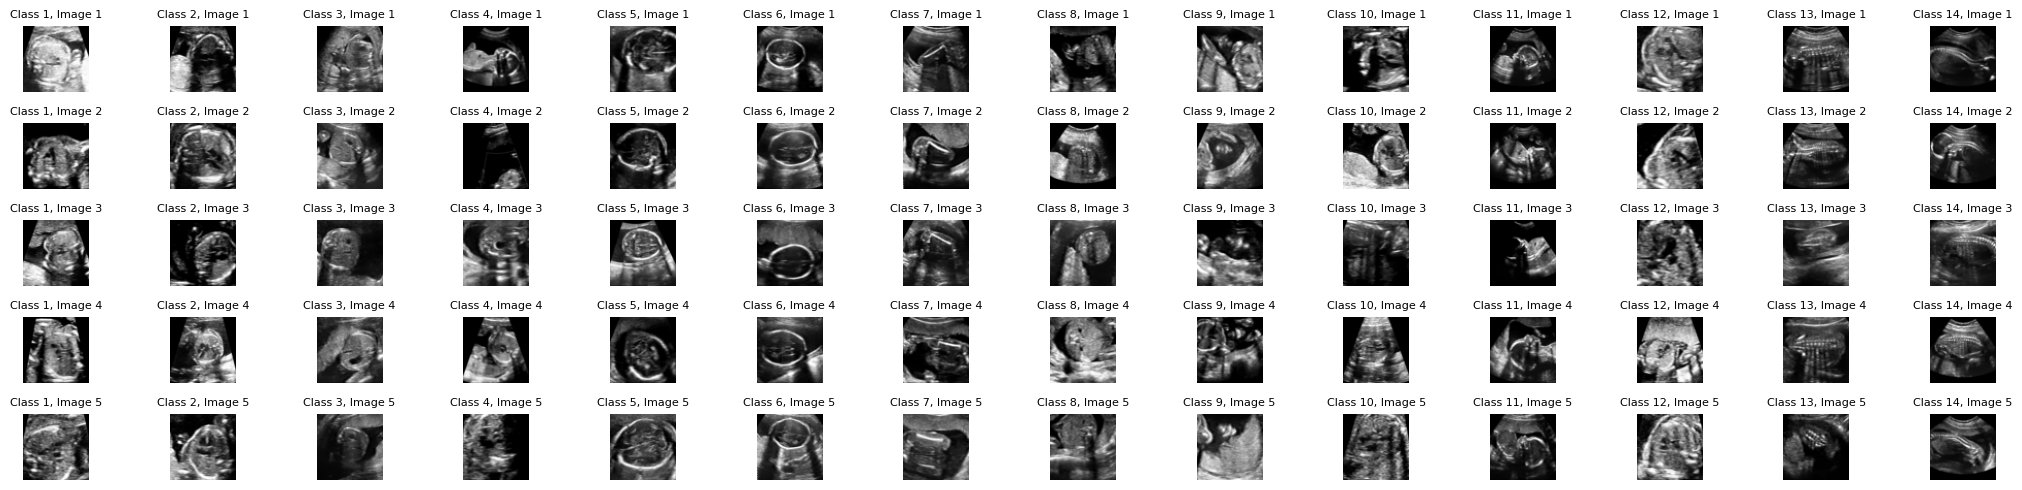

In [10]:
n_img = 5

real_img_tmp_list = [get_images(c, n_img, args, indices_class, images_all) for c in range(num_classes)]
real_img_tmp_tensor = torch.cat(real_img_tmp_list)
display_latent(real_img_tmp_tensor, num_classes, n_img, args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)

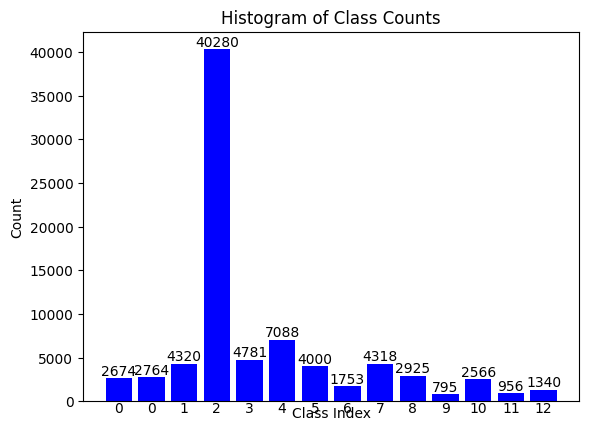

In [11]:
counts = plot_class_distribution(labels_all)

In [12]:
test_class_count = count_classes(testloader)
test_class_count = list(dict(sorted(test_class_count.items())).values())

  0%|          | 0/299 [00:00<?, ?it/s]

# Load Pretrained GAN

/vol/bitbucket/ms922/glad/dm_ultrasound_util.py:647: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(model_path))


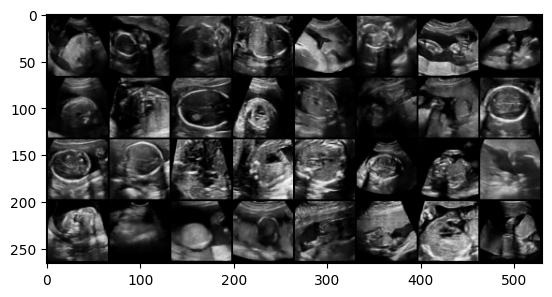

In [13]:
gan_model_path = "./gan/models/net_G_relu_64_video_net_new_epoch_49.pth"
if args.use_gan:
    generator = get_dcgan(args, gan_model_path, ngf=64, channel=channel, display_img=True, unnormalize=unnormalize)
else:
    generator = None

# Training IDM

In [14]:
latents = run_idm(
    args, 
    indices_class, 
    images_all, 
    labels_all,
    channel, 
    num_classes, 
    im_size=im_size, 
    generator=generator, 
    n_sample_list=n_sample_list, 
    is_save_img=True, 
    is_save_latent=True,
    unnormalize=unnormalize
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jack47744. Use `wandb login --relogin` to force relogin


Sample with ratio of 0.01


Training Iterations:   0%|          | 0/1001 [00:00<?, ?it/s]

/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/vol/bitbucket/ms922/myenv/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Save at ./idm_re_3_latents/ultrasound/0__01_ori_0050.pt
Save at ./idm_re_3_latents/ultrasound/0__01_ori_0100.pt
Save at ./idm_re_3_latents/ultrasound/0__01_ori_0150.pt
Save at ./idm_re_3_latents/ultrasound/0__01_ori_0200.pt
Save at ./idm_re_3_latents/ultrasound/0__01_ori_0250.pt


In [ ]:
latent_dir = f"./{args.method}_latents/{args.dataset}" if args.use_gan else f"./{args.method}_latents/{args.dataset}_no_gan"
if args.use_sample_ratio:
    save_name = f'{str(args.sample_ratio).replace(".", "__")}_ori_1000.pt'
else:
    save_name = f"{args.ipc}_ori_1000.pt"
latent_path = os.path.join(latent_dir, save_name)
latents_tmp = torch.load(latent_path, map_location=args.device, weights_only=True)
print(latent_path)

./idm_re_1_latents/ultrasound/0__01_ori_1000.pt


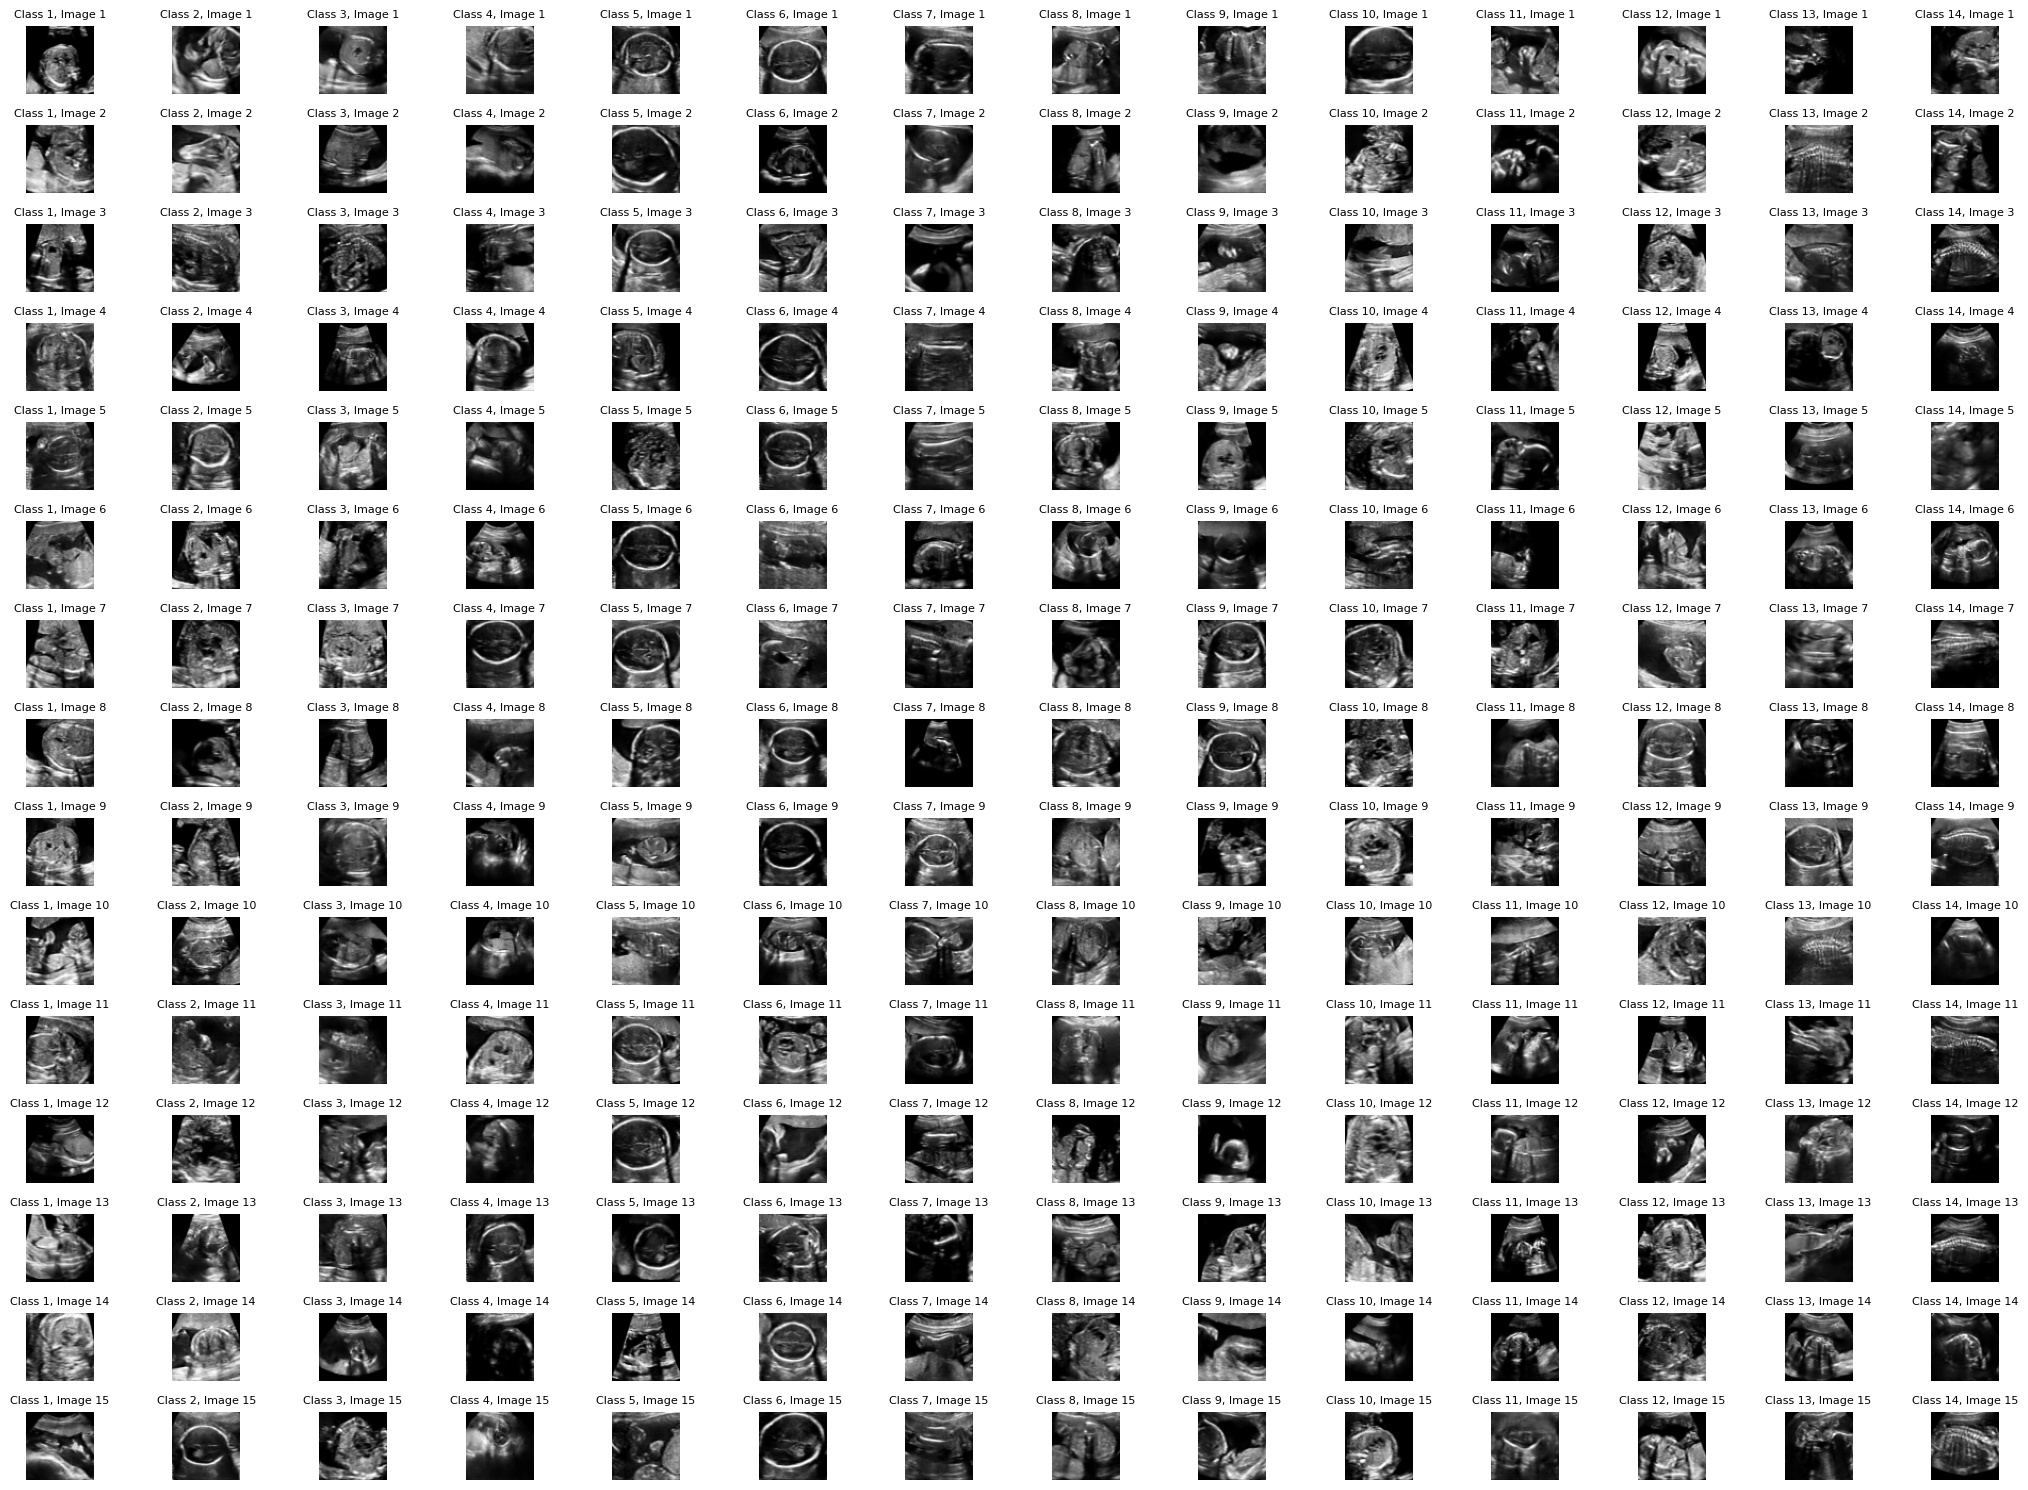

In [ ]:
if args.use_sample_ratio:
    sampled_tensors = sample_tensors(latents_tmp, n_sample_list, min(n_sample_list))
    display_latent(sampled_tensors, num_classes, min(n_sample_list), args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)
else:
    display_latent(latents_tmp, num_classes, args.ipc, args, True, channel=channel, im_size=im_size, unnormalize=unnormalize)

In [ ]:
if args.use_sample_ratio:
    tensor_split = split_tensor_to_list(latents_tmp, n_sample_list)

In [ ]:
embed_list = get_embed_list(args, channel, num_classes, im_size, num_net=10)

if args.use_sample_ratio:
    mse_latent_dict, latent_embed_mean_list, img_latent_mean_all_list = get_most_similar_img(
        tensor_split, args, indices_class, images_all, is_stack=False, embed_list=embed_list, ret_img_latent=True
    )
else:
    mse_latent_dict, latent_embed_mean_list = get_most_similar_img(latents_tmp, args, embed_list=embed_list)

  0%|          | 0/2674 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/4320 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/40280 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/4781 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/7088 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1753 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/4318 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/2925 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/795 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2566 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/956 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1340 [00:00<?, ?it/s]

Processing Latents:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# save_path = f"./experiment_res/embedding_plot/{args.method}"
# if not os.path.exists(save_path):
#     os.makedirs(save_path)
# plot_embedding(images_all, img_latent_mean_all_list, mse_latent_dict, args, save_path)

In [ ]:
mse_latent_dict_dir = f"./{args.method}_mse_latent_dict" if args.use_gan else f"./{args.method}_mse_latent_dict_no_gan"
if not os.path.exists(mse_latent_dict_dir):
    os.makedirs(mse_latent_dict_dir)

In [ ]:
if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
else:
    save_name = f"{args.dataset}_{args.ipc:03d}.pkl"

mse_latent_dict_path = os.path.join(mse_latent_dict_dir, save_name)
with open(mse_latent_dict_path, 'wb') as file:
    pickle.dump(mse_latent_dict, file)
    print(f"Save at {mse_latent_dict_path}")

Save at ./idm_re_0_mse_latent_dict/ultrasound_0__01.pkl


In [ ]:
# Open the file in read-binary mode and load the dictionary
if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
else:
    save_name = f"{args.dataset}_{args.ipc:03d}.pkl"

mse_latent_dict_path = os.path.join(mse_latent_dict_dir, save_name)
with open(mse_latent_dict_path, 'rb') as file:
    mse_latent_dict = pickle.load(file)
    print(f"Load: {mse_latent_dict_path}")

Load: ./idm_re_1_mse_latent_dict/ultrasound_0__01.pkl


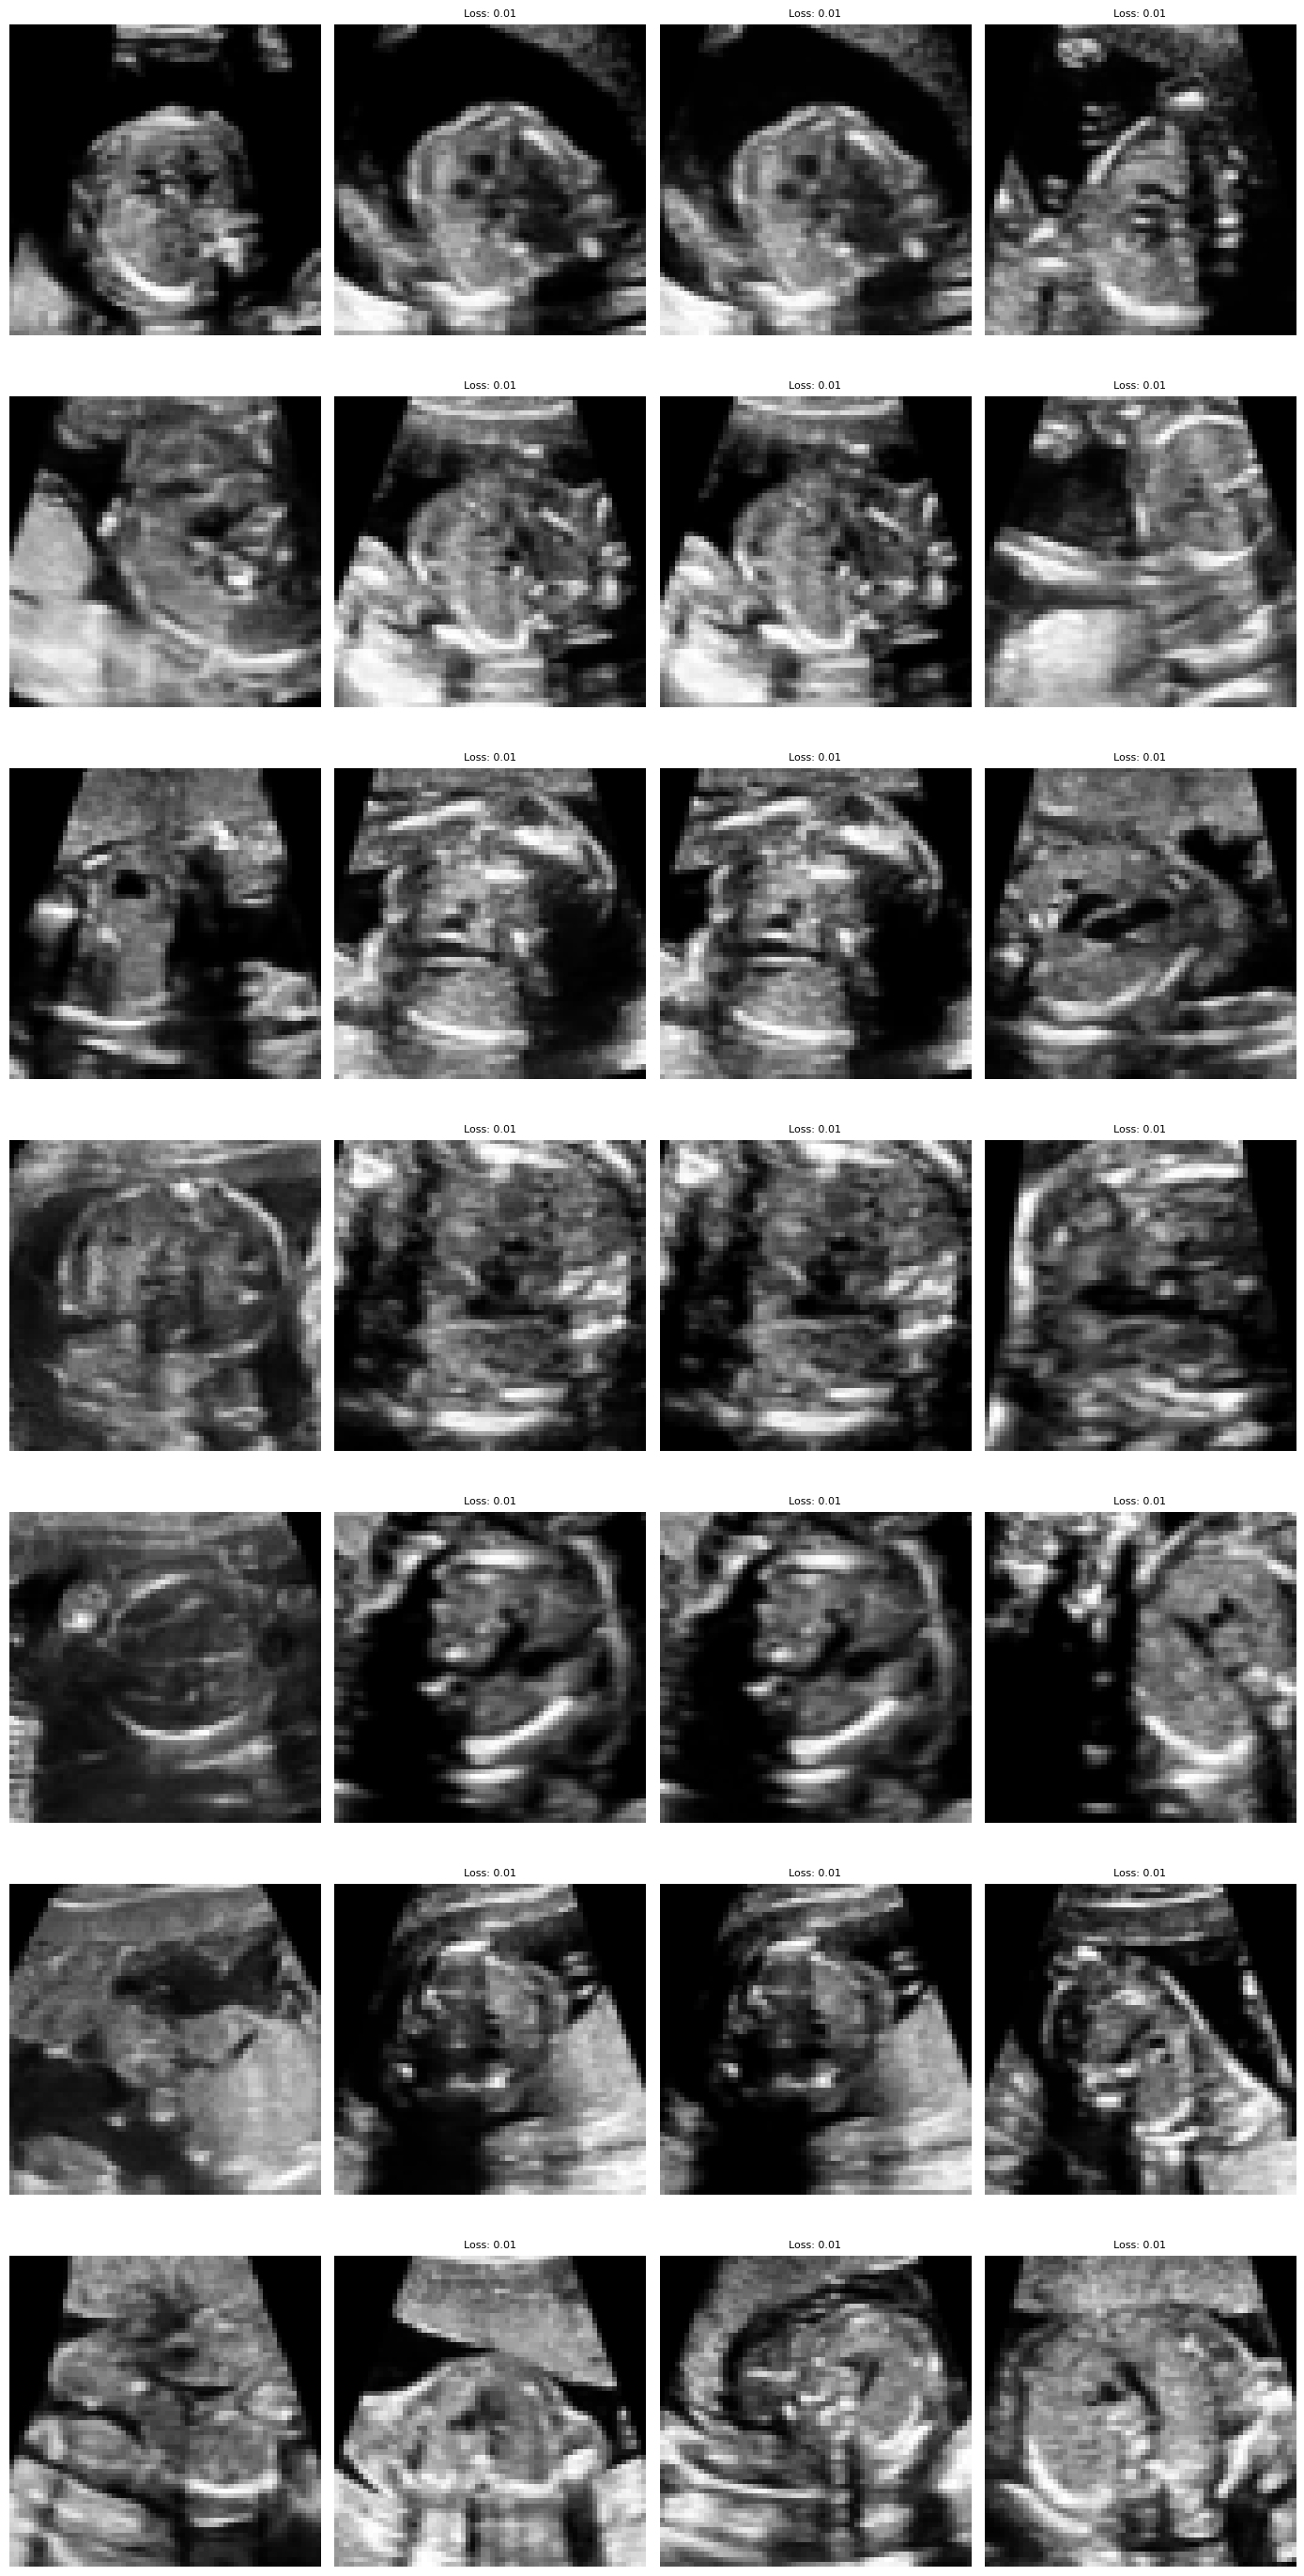

In [ ]:
top_k = 3
num_img = 7

for c in range(num_classes):
    all_img_top_k_list = []
    similarity_loss_list = []
    for latent_idx in range(num_img):

        k = (c, latent_idx)
        mse_val_list = sorted(mse_latent_dict[k])[:top_k]
        top_img_idx = [e[1] for e in mse_val_list]
        similarity_loss = [e[0] for e in mse_val_list]
        top_imgs = images_all[top_img_idx].detach().cpu()
        if args.use_sample_ratio:
            latent = torch.unsqueeze(tensor_split[c][latent_idx], 0).detach().cpu()
        else:
            latent = torch.unsqueeze(latents_tmp[(c, latent_idx)], 0).detach().cpu()
        if len(latent.shape) == 3:
            latent = torch.unsqueeze(latent, 0)
        # print(latent.shape, top_imgs.shape)
        all_img_top_k = torch.cat((latent, top_imgs))
        all_img_top_k_list.append(all_img_top_k)
        similarity_loss_list.append(similarity_loss)
        

    plot_images_with_similarity(args, all_img_top_k_list, similarity_loss_list, num_img, num_classes=num_classes, unnormalize=unnormalize)
    break

# Train Top K Images

In [ ]:
args.epoch_eval_train = 500

In [ ]:
torch.random.manual_seed(0)
np.random.seed(0)
random.seed(0)

top_image_list, top_label_list, _ = get_top_img(images_all, mse_latent_dict)
top_image_list = torch.cat(top_image_list)
top_label_list = torch.tensor(top_label_list)

 ----- top k: 1 ----- 


  0%|          | 0/618 [00:00<?, ?it/s]

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

res_subset_dict = {}

model_eval_list = ["ConvNet", "ResNet18", "VGG11", "ViT"]
eval_pool_dict = get_eval_lrs(args)
for model_eval in model_eval_list:
    args.lr_net = eval_pool_dict[model_eval]
    print(f"model: {model_eval}")
    metric_train_all = []
    metric_test_all = []
    for it_eval in range(args.num_eval):
        torch.cuda.empty_cache()
        gc.collect()
        net = get_network(model_eval, channel, num_classes, im_size, depth=args.depth, width=args.width).to(args.device) # get a random model
        net.train()
        _, metric_train_list, metric_test_list = evaluate_synset(
            it_eval, net, top_image_list, top_label_list, testloader, args, decay="cosine", aug=True
        )
        metric_train_all.append(metric_train_list)
        metric_test_all.append(metric_test_list)
    res_subset_dict[model_eval] = metric_test_all

model: ConvNet


100%|██████████| 500/500 [00:54<00:00,  9.14it/s]


model: ResNet18


100%|██████████| 500/500 [02:32<00:00,  3.28it/s]


model: VGG11


100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


model: ViT


100%|██████████| 500/500 [01:41<00:00,  4.94it/s]


In [ ]:
dir = f"../experiment_res/subset_{args.method}" if args.use_gan else f"../experiment_res/subset_{args.method}_no_gan"

if args.use_sample_ratio:
    save_name = f'{args.dataset}_{str(args.sample_ratio).replace(".", "__")}.pkl'
    file_prefix = f'subset_{args.method}_{str(args.sample_ratio).replace(".", "__")}_' if args.use_gan else f'subset_{args.method}_no_gan_{str(args.sample_ratio).replace(".", "__")}_'
else:
    save_name = f'{args.dataset}_{str(args.ipc).replace(".", "__")}.pkl'
    file_prefix = f"subset_{args.method}_" if args.use_gan else f"subset_{args.method}_no_gan_"


save_res_dict_excel(args, res_subset_dict, test_class_count, dir, file_prefix=file_prefix)


Accuracy avg:0.730701, std:0.002766
Save at: ../experiment_res/subset_idm_re_1/subset_idm_re_1_0__01_ultrasound_050_ConvNet.xlsx
Accuracy avg:0.740177, std:0.004492
Save at: ../experiment_res/subset_idm_re_1/subset_idm_re_1_0__01_ultrasound_050_ResNet18.xlsx
Accuracy avg:0.675799, std:0.005364
Save at: ../experiment_res/subset_idm_re_1/subset_idm_re_1_0__01_ultrasound_050_VGG11.xlsx
Accuracy avg:0.679288, std:0.008457
Save at: ../experiment_res/subset_idm_re_1/subset_idm_re_1_0__01_ultrasound_050_ViT.xlsx
